# Bayesian Linear Regression on House Sales Prices

This notebook will involve implementing Bayesian Inference methods, in particular, Bayesian Linear Regression. 

**Data:**   

The data is Housing Prices Dataset found on Kaggle through the following link: https://www.kaggle.com/alphaepsilon/housing-prices-dataset.

This dataset contains 81 attributes on various characteristics related to each house sold. The target is SalePrice.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

from IPython.core.pylabtools import figsize

from scipy.stats import percentileofscore
from scipy import stats
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error


#PyMC3 for Bayesian Inference
import pymc3 as pm

import arviz as az

import theano.tensor as T
import theano
from theano import shared
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.5


## Import Data

In [2]:
df = pd.read_csv('dataset/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.shape

(1460, 81)

In [4]:
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

## Data Exploration

### Target variable - SalePrice

In [5]:
#distribution of price
df['SalePrice'].describe().round()

count      1460.0
mean     180921.0
std       79443.0
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

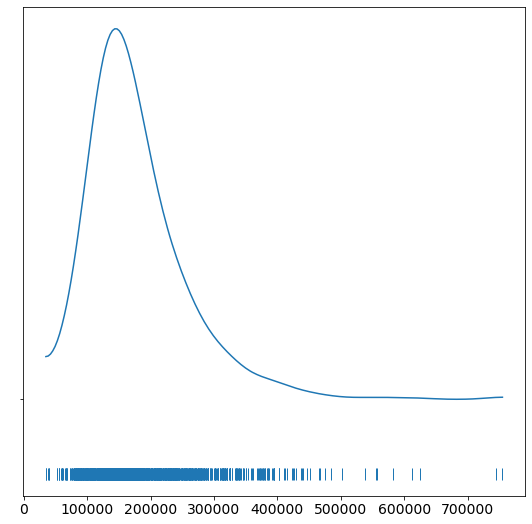

In [6]:
az.plot_kde(df['SalePrice'].values, rug=True)
plt.yticks([0], alpha=0);

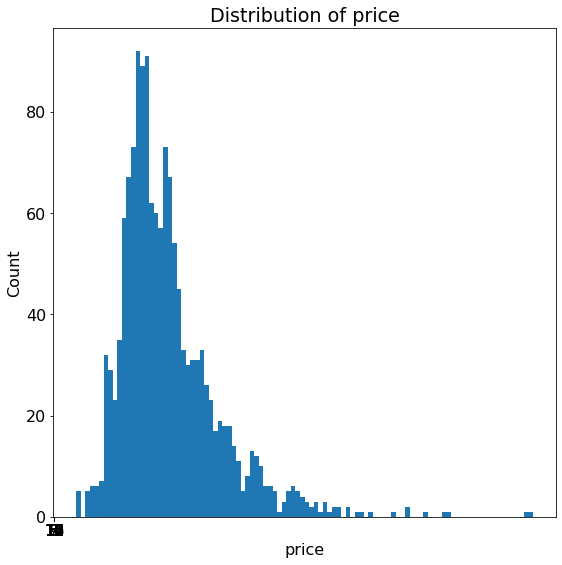

In [7]:
#histogram of price
plt.hist(df['SalePrice'], bins=100)
plt.xlabel('price'); plt.ylabel('Count'); plt.title('Distribution of price');
plt.xticks(list(range(5, 20)));

In [8]:
#calculate percentile for price
df['percentile'] = df['SalePrice'].apply(lambda x: percentileofscore(df['SalePrice'], x))

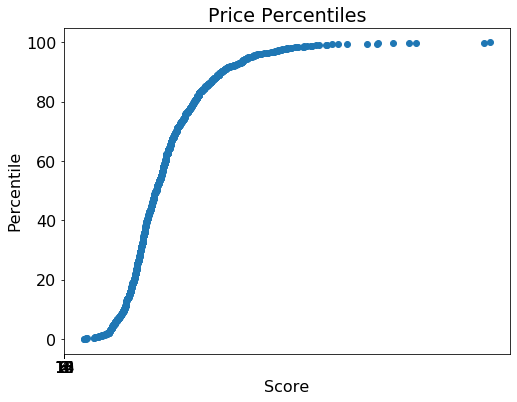

In [9]:
#plot percentiles for price
plt.figure(figsize = (8, 6))
plt.plot(df['SalePrice'], df['percentile'], 'o')
plt.xticks(range(0, 20, 2), range(0, 20, 2))
plt.xlabel('Score'); plt.ylabel('Percentile'); plt.title('Price Percentiles');

In [10]:
print('50th percentile price: ${}'.format(np.min(df.loc[df['percentile'] > 50, 'SalePrice'])))
print('Minimum price needed for 90th percentile: ${}'.format(np.min(df.loc[df['percentile'] > 90, 'SalePrice'])))

50th percentile price: $163000
Minimum price needed for 90th percentile: $278000


The KDE plot and histogram of house sale price shows a Gaussian-like distribution, except for about several dozens of data points that are far away from the mean.

Assuming that a Gaussian distribution is a proper description of house sale price, since the mean and standard deviation are not known, priors must be set for both of them. Therefore, a reasonable model could be to perform Gaussian inferences on the house price data. 

Choices for price likelihood function:

The sale price is modelled as a linear combination of the independent variables. It is assumed that the sale price is normally distributed around the linear combination of independent variables with the same variance around the expected value.

**First, the Models are instantiated in PyMC3 as follows:**   
+ model specifications in PyMC3 are wrapped in a with-statement.
Choices of priors:
+ μ, mean of a population. Normal distribution. Very wide. The possible values of μ are unknown, so priors can be set to reflect this ignorance. From data description statistics, sales price can not be lower than 34000 or higher than 800000, so boundaries of the uniform distribution are set to be 34000 and 800000. 
+ σ, standard deviation of a population. Can only be positive, therefore use HalfNormal distribution, again, very wide.
Choices for ticket price likelihood function:
+ y is an observed variable representing the data that comes from a Normal distribution with the parameters μ and σ.
+ draw 1000 posterior samples using NUTS sampling

Using PyMC3, the model can be written as follows:


In [11]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=34000, upper=800000)
    σ = pm.HalfNormal('σ', sd=80000)
    y = pm.Normal('y', mu=μ, sd=σ, observed=df['SalePrice'].values)
    trace_g = pm.sample(1000, init = 'advi', tune  = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 18,614:   6%|▌         | 12085/200000 [00:04<01:17, 2420.76it/s]
Convergence achieved at 12100
Interrupted at 12,099 [6%]: Average Loss = 22,235
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:01<00:00, 4365.46draws/s]


The "y" specifies the likelihood. This is the way in which PyMC3 is told to condition for the unknown on the known (data). The observed values can be passed as a Python list, a tuple, a NumPy array, or a pandas DataFrame.

Now a gaussian model trace will be plotted - this runs on a Theano graph under the hood.

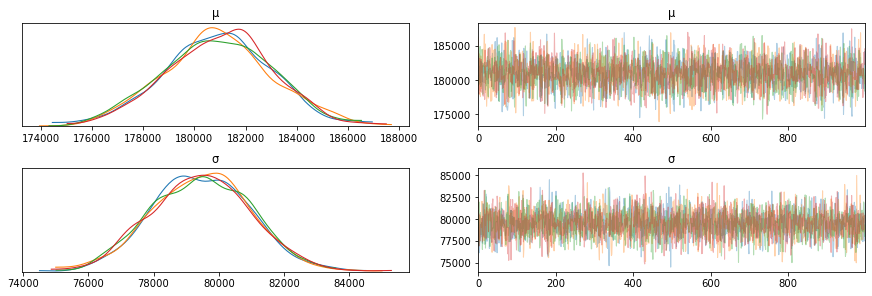

In [12]:
az.plot_trace(trace_g);

On the left is a KDE plot – for each parameter value on the x-axis, there is a probability on the y-axis that provides the likelihood of a parameter value.

On the right is the individual sampled values at each step during the sampling. The trace plot shows visually the plausible values from the posterior.

The above plot has one row for each parameter. For this model, the posterior is bi-dimensional, and so the above figure is showing the marginal distributions of each parameter.

There are a couple of things to see here.
+ The sampling chains for the individual parameters (left side) seem well converged and stationary (there are no large drifts or other odd patterns).
+ The maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters.

Now a joint distributions of parameters will be plotted. There is no apparent correlation between these two parameters. This means there is probably not any collinearity in the model.

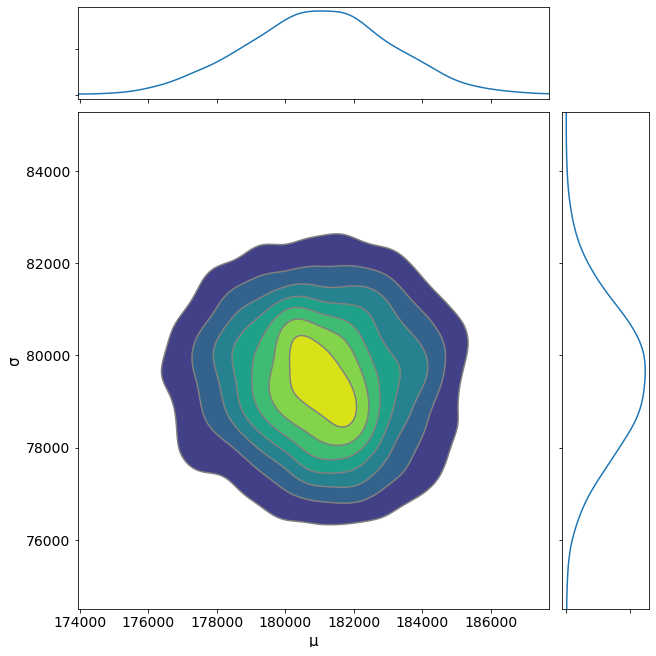

In [13]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

A detailed summary of the posterior distribution for each parameter can be generated, as well as plotted: 

In [14]:
az.summary(trace_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,180929.218,2105.850,176932.173,184781.364,33.895,23.969,3860.0,3860.0,3851.0,3198.0,1.0
σ,79467.597,1510.414,76710.704,82321.980,24.409,17.261,3829.0,3829.0,3825.0,2705.0,1.0


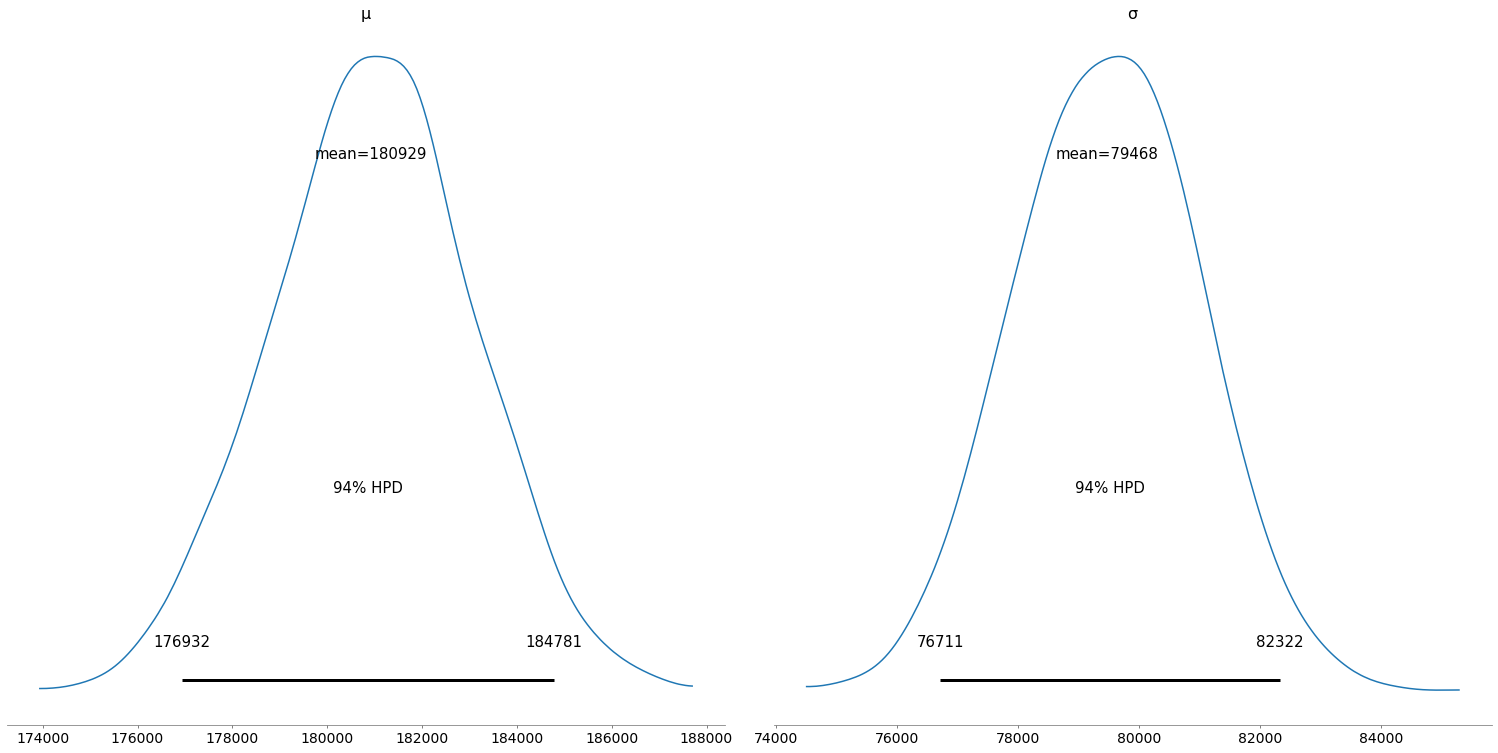

In [15]:
az.plot_posterior(trace_g);

These numbers can be used to interpret and report the results of a Bayesian inference.

Unlike Frequentist statistics, in Bayesian statistics, the entire distribution of the values is is provided.

Every time ArviZ computes and reports a HPD, it will use, by default, a value of 94%. HPD intervals are not the same as confidence intervals; there is 94% probability the belief is between 176913.54 and 184678.94 for the mean sales price.

The convergence of the chains can be verified formally using the Gelman Rubin test. Values close to 1.0 mean convergence.

In [16]:
pm.gelman_rubin(trace_g)

{'μ': 1.0000686873491444, 'σ': 0.9995185526008814}

In [17]:
bfmi = pm.bfmi(trace_g)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace_g).values())

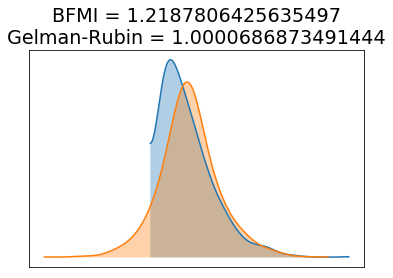

In [18]:
(pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

The model has converged well and the Gelman-Rubin statistic looks good.

**Posterior Predictive Checks**

Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Now that the posterior has been computed, how to use the simulation results to derive predictions can be illustrated. The following function will randomly draw 500 samples of parameters from the trace. Then, for each sample, it will draw 1460 random numbers from a normal distribution specified by the values of μ and σ in that sample.

In [19]:
ppc = pm.sample_ppc(trace_g, samples=500, model=model_g)

100%|██████████| 500/500 [00:00<00:00, 1255.25it/s]


In [20]:
np.asarray(ppc['y']).shape

(500, 1460)

Now, ppc contains 500 generated data sets (containing 1460 samples each), each using a different parameter setting from the posterior.

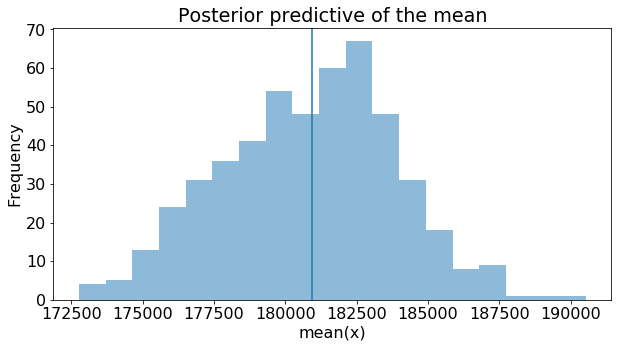

In [21]:
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(df.SalePrice.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

The inferred mean is very close to the actual sales price mean.

### Further Exploratory Analysis

In [22]:
#retain only small number of columns for analysis - those which are heavily dominated by single cat
df['TotSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] + df['GrLivArea']
df['TotFullBath'] = df['BsmtFullBath'] + df['FullBath']
df['TotHalfBath'] = df['BsmtHalfBath'] + df['HalfBath']
df['HouseAgeTimeSale'] = df['YrSold'] - df['YearBuilt']
df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']
data = df[['MSZoning','LotArea','TotSF','OverallQual','OverallCond','Neighborhood','HouseAgeTimeSale','RemodelAge','MoSold','YrSold','BedroomAbvGr','TotRmsAbvGrd','TotFullBath','TotHalfBath','SalePrice','percentile']]

data.dtypes

MSZoning             object
LotArea               int64
TotSF                 int64
OverallQual           int64
OverallCond           int64
Neighborhood         object
HouseAgeTimeSale      int64
RemodelAge            int64
MoSold                int64
YrSold                int64
BedroomAbvGr          int64
TotRmsAbvGrd          int64
TotFullBath           int64
TotHalfBath           int64
SalePrice             int64
percentile          float64
dtype: object

It would be interesting to see price distribution within overall condition and overall quality ratings, so for exploratory analysis purposes these will be converted to categorical variables. Month and Year sold will also be made categorical for now.

#### Categorical variables

In [23]:
data1 = data.copy(deep=True)
data1[['OverallCond','OverallQual','YrSold','MoSold']] = data1[['OverallCond','OverallQual','YrSold','MoSold']].astype(str)

In [24]:
#value counts for categorical columns
for col in data1.columns:
    if data1[col].dtype == 'object':
        print('\nColumn Name:', col,)
        print(data1[col].value_counts())


Column Name: MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Column Name: OverallQual
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

Column Name: OverallCond
5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

Column Name: Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

Column Name: MoSold
6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2    

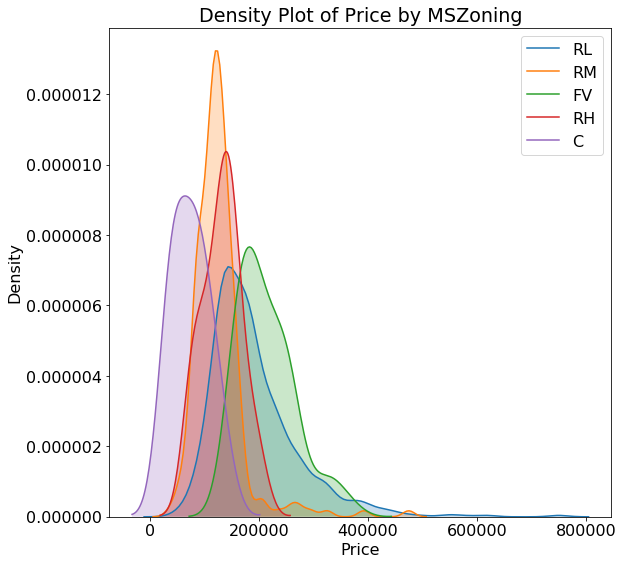

In [25]:
#price distribution by MSZoning status
sns.kdeplot(data1.loc[data1['MSZoning'] == 'RL', 'SalePrice'], label = 'RL', shade = True)
sns.kdeplot(data1.loc[data1['MSZoning'] == 'RM', 'SalePrice'], label = 'RM', shade = True)
sns.kdeplot(data1.loc[data1['MSZoning'] == 'FV', 'SalePrice'], label = 'FV', shade = True)
sns.kdeplot(data1.loc[data1['MSZoning'] == 'RH', 'SalePrice'], label = 'RH', shade = True)
sns.kdeplot(data1.loc[data1['MSZoning'] == 'C (all)', 'SalePrice'], label = 'C', shade = True)
plt.xlabel('Price'); plt.ylabel('Density'); plt.title('Density Plot of Price by MSZoning');

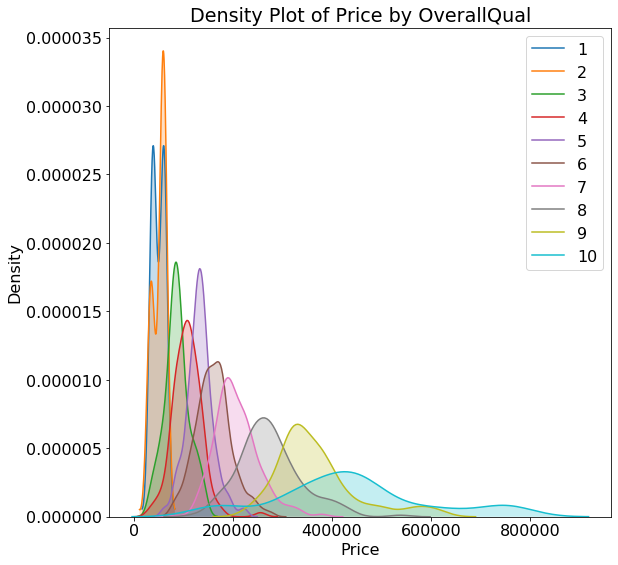

In [26]:
#price distribution by overall quality
sns.kdeplot(data1.loc[data1['OverallQual'] == '1', 'SalePrice'], label = '1', shade = True)
sns.kdeplot(data1.loc[data1['OverallQual'] == '2', 'SalePrice'], label = '2', shade = True)
sns.kdeplot(data1.loc[data1['OverallQual'] == '3', 'SalePrice'], label = '3', shade = True)
sns.kdeplot(data1.loc[data1['OverallQual'] == '4', 'SalePrice'], label = '4', shade = True)
sns.kdeplot(data1.loc[data1['OverallQual'] == '5', 'SalePrice'], label = '5', shade = True)
sns.kdeplot(data1.loc[data1['OverallQual'] == '6', 'SalePrice'], label = '6', shade = True)
sns.kdeplot(data1.loc[data1['OverallQual'] == '7', 'SalePrice'], label = '7', shade = True)
sns.kdeplot(data1.loc[data1['OverallQual'] == '8', 'SalePrice'], label = '8', shade = True)
sns.kdeplot(data1.loc[data1['OverallQual'] == '9', 'SalePrice'], label = '9', shade = True)
sns.kdeplot(data1.loc[data1['OverallQual'] == '10', 'SalePrice'], label = '10', shade = True)
plt.xlabel('Price'); plt.ylabel('Density'); plt.title('Density Plot of Price by OverallQual');

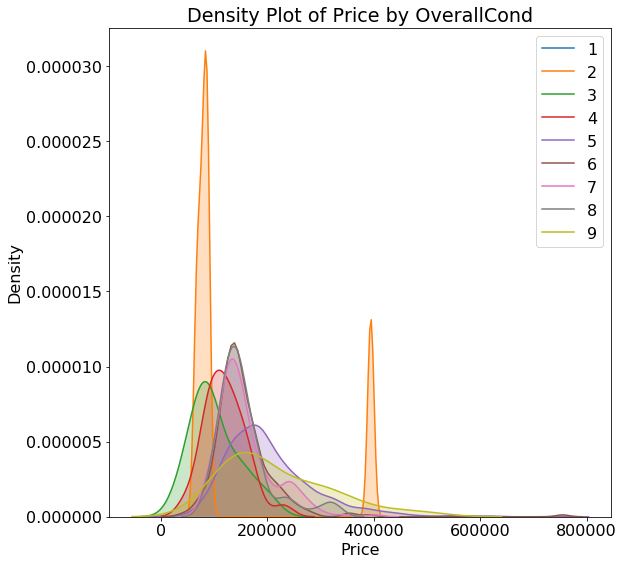

In [27]:
#price distribution by overall condition
sns.kdeplot(data1.loc[data1['OverallCond'] == '1', 'SalePrice'], label = '1', shade = True)
sns.kdeplot(data1.loc[data1['OverallCond'] == '2', 'SalePrice'], label = '2', shade = True)
sns.kdeplot(data1.loc[data1['OverallCond'] == '3', 'SalePrice'], label = '3', shade = True)
sns.kdeplot(data1.loc[data1['OverallCond'] == '4', 'SalePrice'], label = '4', shade = True)
sns.kdeplot(data1.loc[data1['OverallCond'] == '5', 'SalePrice'], label = '5', shade = True)
sns.kdeplot(data1.loc[data1['OverallCond'] == '6', 'SalePrice'], label = '6', shade = True)
sns.kdeplot(data1.loc[data1['OverallCond'] == '7', 'SalePrice'], label = '7', shade = True)
sns.kdeplot(data1.loc[data1['OverallCond'] == '8', 'SalePrice'], label = '8', shade = True)
sns.kdeplot(data1.loc[data1['OverallCond'] == '9', 'SalePrice'], label = '9', shade = True)
plt.xlabel('Price'); plt.ylabel('Density'); plt.title('Density Plot of Price by OverallCond');

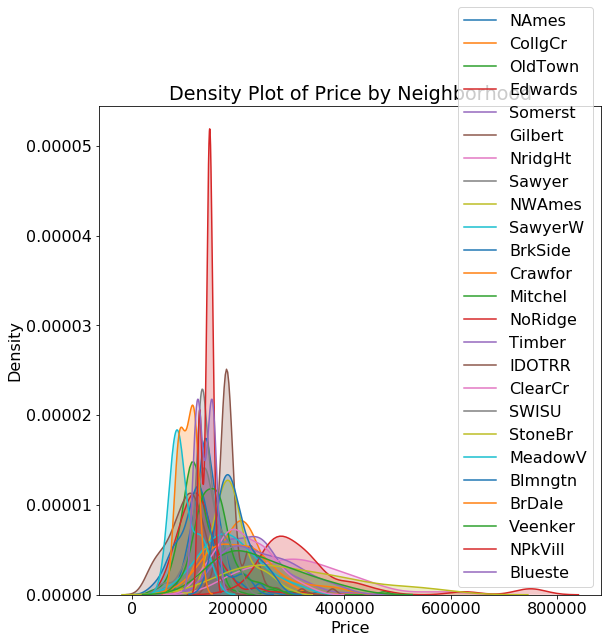

In [28]:
#price distribution by overall condition
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'NAmes', 'SalePrice'], label = 'NAmes', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'CollgCr', 'SalePrice'], label = 'CollgCr', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'OldTown', 'SalePrice'], label = 'OldTown', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'Edwards', 'SalePrice'], label = 'Edwards', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'Somerst', 'SalePrice'], label = 'Somerst', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'Gilbert', 'SalePrice'], label = 'Gilbert', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'NridgHt', 'SalePrice'], label = 'NridgHt', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'Sawyer', 'SalePrice'], label = 'Sawyer', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'NWAmes', 'SalePrice'], label = 'NWAmes', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'SawyerW', 'SalePrice'], label = 'SawyerW', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'BrkSide', 'SalePrice'], label = 'BrkSide', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'Crawfor', 'SalePrice'], label = 'Crawfor', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'Mitchel', 'SalePrice'], label = 'Mitchel', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'NoRidge', 'SalePrice'], label = 'NoRidge', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'Timber', 'SalePrice'], label = 'Timber', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'IDOTRR', 'SalePrice'], label = 'IDOTRR', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'ClearCr', 'SalePrice'], label = 'ClearCr', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'SWISU', 'SalePrice'], label = 'SWISU', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'StoneBr', 'SalePrice'], label = 'StoneBr', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'MeadowV', 'SalePrice'], label = 'MeadowV', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'Blmngtn', 'SalePrice'], label = 'Blmngtn', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'BrDale', 'SalePrice'], label = 'BrDale', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'Veenker', 'SalePrice'], label = 'Veenker', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'NPkVill', 'SalePrice'], label = 'NPkVill', shade = True)
sns.kdeplot(data1.loc[data1['Neighborhood'] == 'Blueste', 'SalePrice'], label = 'Blueste', shade = True)
plt.xlabel('Price'); plt.ylabel('Density'); plt.title('Density Plot of Price by Neighborhood');

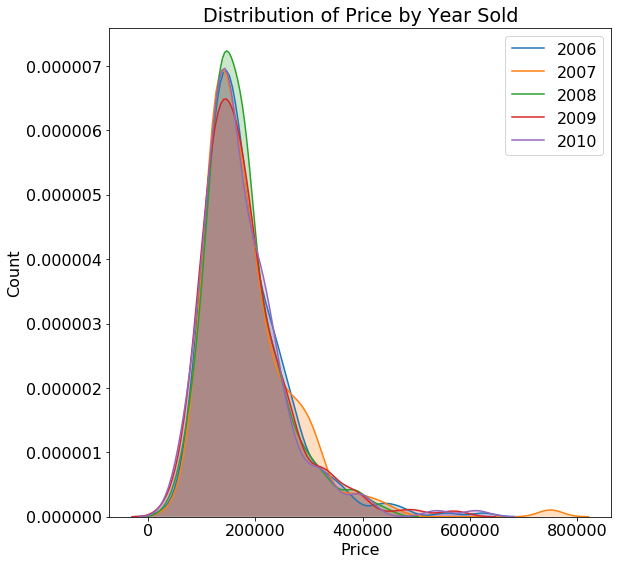

In [29]:
#price distribution by year sold
sns.kdeplot(data1.loc[data1['YrSold'] == '2006', 'SalePrice'], label = '2006', shade = True)
sns.kdeplot(data1.loc[data1['YrSold'] == '2007', 'SalePrice'], label = '2007', shade = True)
sns.kdeplot(data1.loc[data1['YrSold'] == '2008', 'SalePrice'], label = '2008', shade = True)
sns.kdeplot(data1.loc[data1['YrSold'] == '2009', 'SalePrice'], label = '2009', shade = True)
sns.kdeplot(data1.loc[data1['YrSold'] == '2010', 'SalePrice'], label = '2010', shade = True)
plt.xlabel('Price'); plt.ylabel('Count'); plt.title('Distribution of Price by Year Sold');

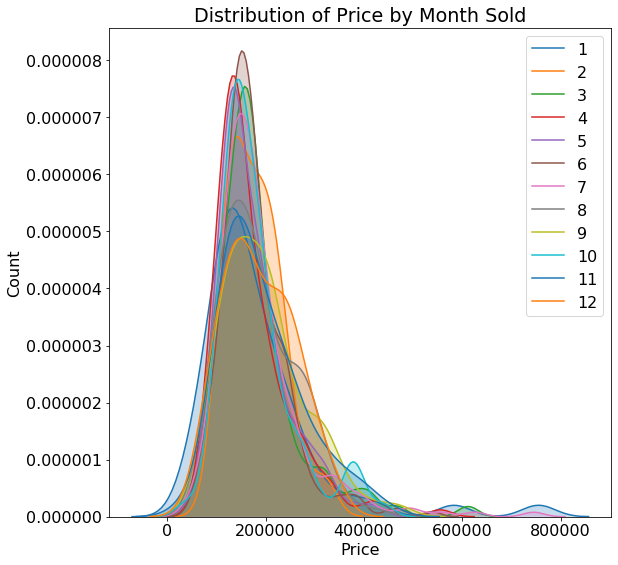

In [30]:
#price distribution by month sold
sns.kdeplot(data1.loc[data1['MoSold'] == '1', 'SalePrice'], label = '1', shade = True)
sns.kdeplot(data1.loc[data1['MoSold'] == '2', 'SalePrice'], label = '2', shade = True)
sns.kdeplot(data1.loc[data1['MoSold'] == '3', 'SalePrice'], label = '3', shade = True)
sns.kdeplot(data1.loc[data1['MoSold'] == '4', 'SalePrice'], label = '4', shade = True)
sns.kdeplot(data1.loc[data1['MoSold'] == '5', 'SalePrice'], label = '5', shade = True)
sns.kdeplot(data1.loc[data1['MoSold'] == '6', 'SalePrice'], label = '6', shade = True)
sns.kdeplot(data1.loc[data1['MoSold'] == '7', 'SalePrice'], label = '7', shade = True)
sns.kdeplot(data1.loc[data1['MoSold'] == '8', 'SalePrice'], label = '8', shade = True)
sns.kdeplot(data1.loc[data1['MoSold'] == '9', 'SalePrice'], label = '9', shade = True)
sns.kdeplot(data1.loc[data1['MoSold'] == '10', 'SalePrice'], label = '10', shade = True)
sns.kdeplot(data1.loc[data1['MoSold'] == '11', 'SalePrice'], label = '11', shade = True)
sns.kdeplot(data1.loc[data1['MoSold'] == '12', 'SalePrice'], label = '12', shade = True)
plt.xlabel('Price'); plt.ylabel('Count'); plt.title('Distribution of Price by Month Sold');

#### Numerical Variables

In [31]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
LotArea,1460.0,10516.828082,9981.264932,1300.000000,7553.500000,9478.500000,11601.500000,215245.0
TotSF,1460.0,4082.512329,1306.309133,668.000000,3168.000000,3941.500000,4768.500000,17394.0
OverallQual,1460.0,6.099315,1.382997,1.000000,5.000000,6.000000,7.000000,10.0
OverallCond,1460.0,5.575342,1.112799,1.000000,5.000000,5.000000,6.000000,9.0
HouseAgeTimeSale,1460.0,36.547945,30.250152,0.000000,8.000000,35.000000,54.000000,136.0
RemodelAge,1460.0,22.950000,20.640653,-1.000000,4.000000,14.000000,41.000000,60.0
MoSold,1460.0,6.321918,2.703626,1.000000,5.000000,6.000000,8.000000,12.0
YrSold,1460.0,2007.815753,1.328095,2006.000000,2007.000000,2008.000000,2009.000000,2010.0
BedroomAbvGr,1460.0,2.866438,0.815778,0.000000,2.000000,3.000000,3.000000,8.0
TotRmsAbvGrd,1460.0,6.517808,1.625393,2.000000,5.000000,6.000000,7.000000,14.0


In [32]:
data[['YrSold','MoSold']] = data[['YrSold','MoSold']].astype(str)

In [33]:
#correlations of numerical values - as condition and quality are ordinal they
#can be treated as numerical for correlation purposes
data.corr()['SalePrice'].sort_values()

HouseAgeTimeSale   -0.523350
RemodelAge         -0.509079
OverallCond        -0.077856
BedroomAbvGr        0.168213
TotHalfBath         0.250628
LotArea             0.263843
TotRmsAbvGrd        0.533723
TotFullBath         0.582934
TotSF               0.777123
OverallQual         0.790982
percentile          0.883647
SalePrice           1.000000
Name: SalePrice, dtype: float64

#### Correlations of categorical variables using One-Hot Encoding

In [34]:
#select categorical variables
category_df = data.select_dtypes('object')

#one hot encode variables
dummy_df = pd.get_dummies(category_df)

#put price back in dataframe
dummy_df['price'] = data['SalePrice']
dummy_df.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,...,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,price
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,208500
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,181500
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,223500
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,140000
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,250000


In [35]:
#correlations in one-hot encoded dataframe
dummy_df.corr()['price'].sort_values()

MSZoning_RM            -0.288065
Neighborhood_OldTown   -0.192189
Neighborhood_NAmes     -0.188513
Neighborhood_Edwards   -0.179949
Neighborhood_IDOTRR    -0.164056
Neighborhood_BrkSide   -0.143648
Neighborhood_Sawyer    -0.128394
Neighborhood_MeadowV   -0.112544
MSZoning_C (all)       -0.111257
Neighborhood_BrDale    -0.101303
MSZoning_RH            -0.065429
Neighborhood_SWISU     -0.063705
Neighborhood_Mitchel   -0.057845
MoSold_5               -0.043714
MoSold_4               -0.038774
Neighborhood_NPkVill   -0.037910
YrSold_2008            -0.022990
MoSold_6               -0.020324
Neighborhood_Blueste   -0.020250
YrSold_2010            -0.016392
YrSold_2009            -0.010292
MoSold_2               -0.007355
MoSold_10              -0.004354
MoSold_1                0.005980
MoSold_3                0.008219
YrSold_2006             0.010732
MoSold_8                0.014185
MoSold_12               0.014465
Neighborhood_SawyerW    0.014560
Neighborhood_Blmngtn    0.019066
Neighborho

### Group Comparison

It would be interesting to see how price compares under different neighbourhoods. The focus here is on estimating the effect size, that is, quantifying the difference between neighbourhoods. To compare neighbourhoods, the mean of each neighbourhood will be used. A posterior distribution of the differences of means between neighbourhoods will be obtained.   

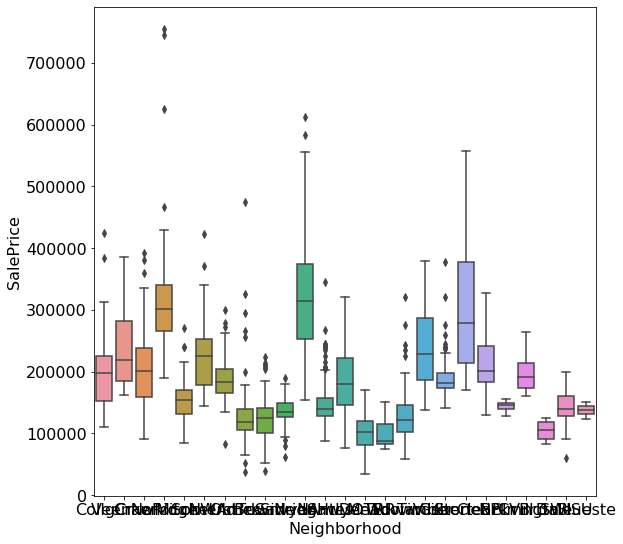

In [36]:
sns.boxplot(x='Neighborhood', y='SalePrice', data=data);

Three variables are created: 
+ the price variable, representing the sale price, 
+ the idx variable, a categorical dummy variable to encode the quality ratings with numbers, 
+ the groups variable, with the number of quality rating levels (10)

In [37]:
neighborhoods = data['Neighborhood'].unique()

In [38]:
price = data.SalePrice.values
idx = pd.Categorical(data1['Neighborhood'],
                     categories=neighborhoods).codes
groups = len(np.unique(idx))

The model for the group comparison problem is almost the same as the previous model, the only difference is that μ and σ are going to be vectors instead of scalar variables. This means that for the priors, a shape argument is provided and for the likelihood, the means and sds variables are properly indexed using the idx variable:

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 3.3687e+06:  15%|█▍        | 29655/200000 [00:13<01:16, 2219.06it/s]
Convergence achieved at 29800
Interrupted at 29,799 [14%]: Average Loss = 6.7611e+10
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, m]
Sampling 4 chains: 100%|██████████| 8000/8000 [03:23<00:00, 39.24draws/s]


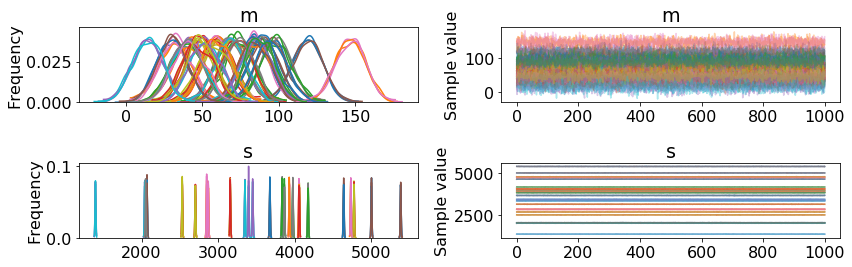

In [39]:
with pm.Model() as comparing_groups:
    m = pm.Normal('m', mu=0, sd=10, shape=groups)
    s = pm.HalfNormal('s', sd=10, shape=groups)

    y = pm.Normal('y', mu=m[idx], sd=s[idx], observed=price)

    trace_groups = pm.sample(1000, init='advi', tune=1000)

pm.plots.traceplot(trace_groups);

This time, there is a KDE plot of mu and sd for every group (i.e. neighbourhood).

In [40]:
flat_price = az.from_pymc3(trace=trace_groups)
price_gaussian = az.summary(flat_price)
price_gaussian

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m[0],118.541,10.120,99.124,137.274,0.163,0.115,3877.0,3877.0,3877.0,3075.0,1.00
m[1],31.936,10.281,12.354,50.552,0.102,0.085,10179.0,7334.0,10144.0,2935.0,1.00
m[2],68.025,10.026,48.634,86.438,0.108,0.078,8654.0,8285.0,8718.0,3121.0,1.00
m[3],60.277,10.049,41.884,79.170,0.114,0.083,7790.0,7345.0,7762.0,2800.0,1.00
m[4],68.133,9.871,49.739,86.528,0.117,0.086,7060.0,6656.0,7000.0,2670.0,1.00
m[5],89.770,9.922,70.665,107.904,0.139,0.098,5128.0,5128.0,5300.0,3094.0,1.00
m[6],84.022,10.076,65.682,103.130,0.139,0.099,5258.0,5128.0,5284.0,3215.0,1.00
m[7],98.167,10.214,78.520,117.229,0.139,0.098,5379.0,5379.0,5382.0,2651.0,1.00
m[8],72.392,9.921,53.176,90.306,0.115,0.082,7416.0,7343.0,7425.0,3302.0,1.00
m[9],84.841,10.027,66.060,102.982,0.126,0.089,6379.0,6379.0,6416.0,2480.0,1.00


There are clearly significant differences between at least some groups on mean.

To make it more visual, the differences between each rating level can be plotted.
+ Cohen's d is an appropriate effect size for the comparison between two means. Cohen's d introduces the variability of each group by using their standard deviations.
+ probability of superiority (ps) is defined as the probability that a data point taken at random from one group has a larger value than one taken at random from another group.

Given the large number of categories (10) and so the large number of resulting comparisons, only a sample of the comparisons will be plotted.

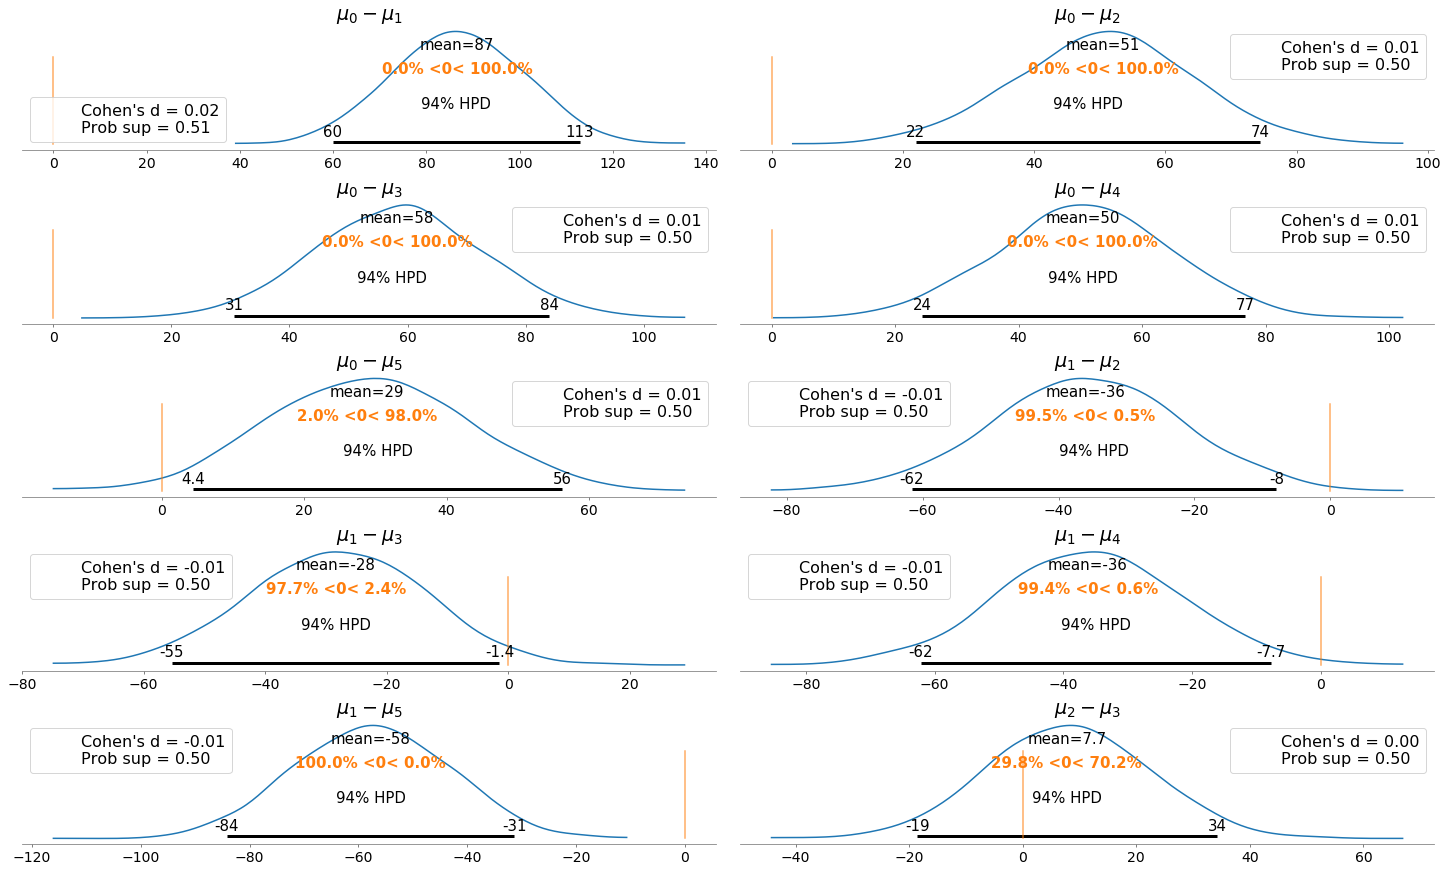

In [41]:
dist = stats.norm()

_, ax = plt.subplots(5, 2, figsize=(20, 12), constrained_layout=True)

comparisons = [(i, j) for i in range(6) for j in range(i+1, 6)]
pos = [(k, l) for k in range(5) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_groups['m'][:, i] - trace_groups['m'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_groups['s'][:, i]**2 + trace_groups['s'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend();

## Variable Selection - 5 Most Correlated Variables with Price

In [42]:
#function that takes in a dataframe, finds most correlated variables with price
#and returns training and testing datasets
def format_data(df):
    #target is price
    labels = df['SalePrice']
    
    #drop percentiles from features
    df = df.drop(columns=['percentile'])
    
    #one-hot encoding of categorical variables
    df = pd.get_dummies(df)
    
    #find correlations with price
    most_correlated = df.corr().abs()['SalePrice'].sort_values(ascending=False)
    
    #maintain top 10 most correlated features with price
    most_correlated = most_correlated[:6]
    
    df = df.loc[:, most_correlated.index]
    
    #split into training/testing sets with 25% split
    X_train, X_test, y_train, y_test = train_test_split(df, labels, 
                                                        test_size = 0.25,
                                                        random_state=42)
    
    return X_train, X_test, y_train, y_test

In [43]:
X_train, X_test, y_train, y_test = format_data(data)
X_train.head()

,SalePrice,OverallQual,TotSF,TotFullBath,TotRmsAbvGrd,HouseAgeTimeSale
1023,191000,7,4354,2,7,3
810,181000,6,3658,2,5,32
1384,105000,6,3076,1,6,70
626,139900,5,3822,1,6,47
813,157900,6,4326,1,7,49


In [44]:
print(X_train.shape)
print(X_test.shape)

(1095, 6)
(365, 6)


#### Pair Plot of Selected Variables

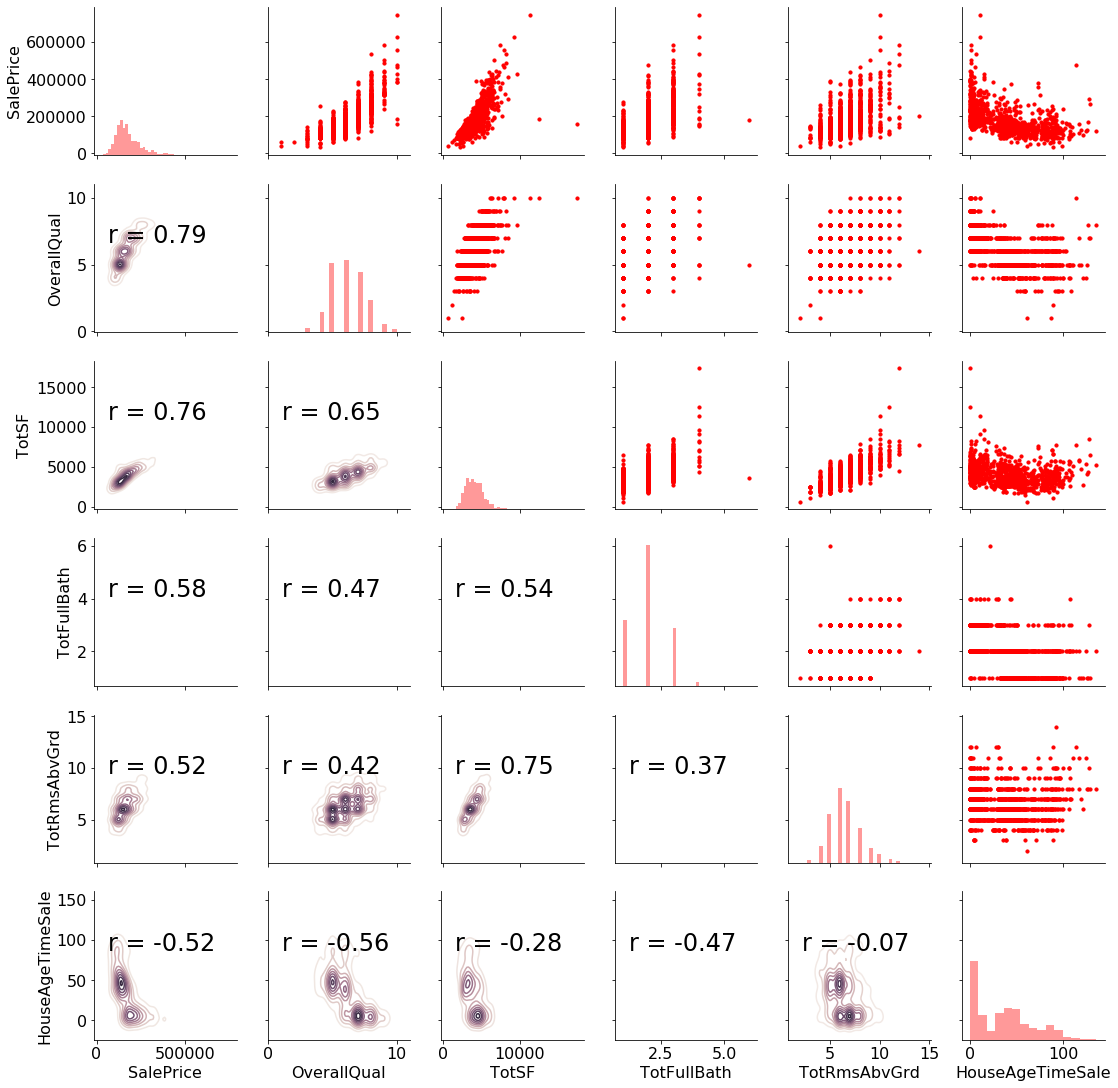

In [45]:
#calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

#pair grid set up
g = sns.PairGrid(X_train)

#scatter plot on upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

#distribution on diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

#density plot and correlation coefficients on lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

#### Selected Variables Distribution in Relation to Median

In [46]:
#create relation to median price column
X_plot = X_train.copy()
X_plot['relation_median'] = (X_plot['SalePrice'] >= 450000)
X_plot['relation_median'] = X_plot['relation_median'].replace({True: 'above', False: 'below'})
X_plot = X_plot.drop(columns='SalePrice')

In [47]:
X_plot.columns

Index(['OverallQual', 'TotSF', 'TotFullBath', 'TotRmsAbvGrd',
       'HouseAgeTimeSale', 'relation_median'],
      dtype='object')

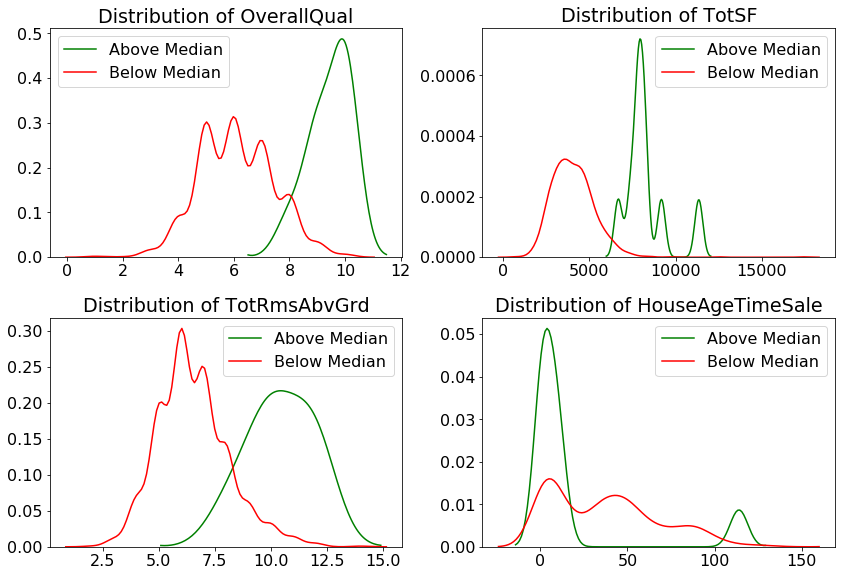

In [48]:
plt.figure(figsize=(12, 12))
#plot distribution of variables coloured
#by relation to median price
X_plot2 = X_plot[['OverallQual', 'TotSF', 'TotRmsAbvGrd','HouseAgeTimeSale']]
for i, col in enumerate(X_plot2.columns):
    plt.subplot(3, 2, i + 1)
    subset_above = X_plot[X_plot['relation_median'] == 'above']
    subset_below = X_plot[X_plot['relation_median'] == 'below']
    
    try:
        subset_above[col]=[float(x) for x in subset_above[col]]
        subset_below[col]=[float(x) for x in subset_below[col]]
    except ValueError:
        print('Line {i} is corrupt!'.format(i = index))
        break
        
    sns.kdeplot(subset_above[col], label = 'Above Median', color = 'green')
    sns.kdeplot(subset_below[col], label = 'Below Median', color = 'red')
    plt.legend(); plt.title('Distribution of %s' % col)
    
plt.tight_layout()

#### Scale data

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train[['OverallQual', 'TotSF', 'TotFullBath', 'TotRmsAbvGrd','HouseAgeTimeSale']] = scaler.fit_transform(X_train[['OverallQual', 'TotSF', 'TotFullBath', 'TotRmsAbvGrd','HouseAgeTimeSale']])
X_test[['OverallQual', 'TotSF', 'TotFullBath', 'TotRmsAbvGrd','HouseAgeTimeSale']] = scaler.transform(X_test[['OverallQual', 'TotSF', 'TotFullBath', 'TotRmsAbvGrd','HouseAgeTimeSale']])

## Establish Benchmarks
### Metrics

As this is a regression problem, the metrics used will be:
+ Mean Absolute Error (MAE): Average of absolute value of the difference between predictions and the true values
+ Root Mean Squared Error (RMSE): The square root of the average of the squared differences between the predictions and the true values.

The mean absolute error is more interpretable, but the root mean squared error penalises larger errors more heavily. Either one may be appropriate depending on the situation.

In [50]:
#calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
    return mae, rmse

### Naive Baseline

For a regression task, a simple naive baseline is to guess the median value on the training set for all testing cases. If the machine learning model cannot better this simple baseline, then a different approach should be tried.

In [51]:
#naive baseline is median
median_pred = X_train['SalePrice'].median()
median_preds = [median_pred for _ in range(len(X_test))]
true = X_test['SalePrice']

In [52]:
#display naive baseline metrics
mb_mae, mb_rmse = evaluate_predictions(median_preds, true)
print('Median Baseline  MAE: {:.4f}'.format(mb_mae))
print('Median Baseline RMSE: {:.4f}'.format(mb_rmse))

Median Baseline  MAE: 57217.3205
Median Baseline RMSE: 84787.1174


### Standard Machine Learning Models
#### Training and testing the models

In [53]:
#evaluate several models
def evaluate(X_train, X_test, y_train, y_test):
    
    #names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    X_train = X_train.drop(columns='SalePrice')
    X_test = X_test.drop(columns='SalePrice')
    
    #instantiate models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    #dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    #train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        #metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        #insert results into dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    #median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [54]:
results = evaluate(X_train, X_test, y_train, y_test)

#### Visual Comparison of Models

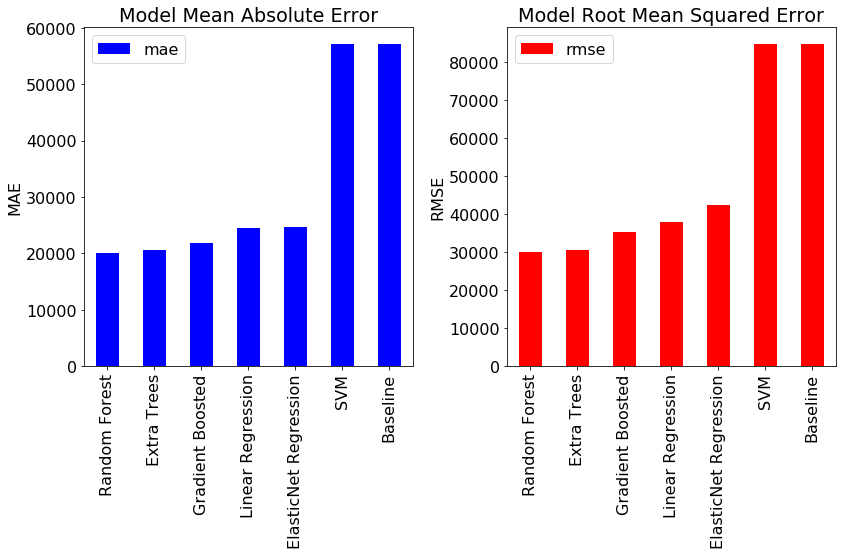

In [55]:
figsize(12, 8)
matplotlib.rcParams['font.size'] = 16

#RMSE
ax =  plt.subplot(1, 2, 1)
results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'b', ax = ax)
plt.title('Model Mean Absolute Error'); plt.ylabel('MAE');

#median absolute percentage error
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'r', ax = ax)
plt.title('Model Root Mean Squared Error'); plt.ylabel('RMSE');

plt.tight_layout()

In [56]:
results

,mae,rmse
Linear Regression,24522.3,38013.2
ElasticNet Regression,24696.2,42239.6
Random Forest,20016.1,29912.9
Extra Trees,20678.2,30560.6
SVM,57104.8,84690.9
Gradient Boosted,21879.5,35365
Baseline,57217.3,84787.1


In [57]:
print('The Random Forest regressor is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Random Forest', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))

The Random Forest regressor is 65.02% better than the baseline.


#### Formula from Ordinary Least Squares Linear Regression

In [58]:
lr = LinearRegression()
lr.fit(X_train.drop(columns='SalePrice'), y_train)

ols_formula = 'SalePrice = %0.2f +' % lr.intercept_
for i, col in enumerate(X_train.columns[1:]):
    ols_formula += ' %0.2f * %s +' % (lr.coef_[i], col)
    
' '.join(ols_formula.split(' ')[:-1])

'SalePrice = 181712.29 + 30764.98 * OverallQual + 31574.01 * TotSF + 8046.51 * TotFullBath + 332.50 * TotRmsAbvGrd + -10558.52 * HouseAgeTimeSale'

## Implementing Bayesian Linear Regression
### Formula

In [59]:
#formula for Bayesian Linear Regression
x = (' + '.join(['%s' % variable for variable in X_train.columns[1:]]))
formula = 'SalePrice ~ '+ (x)
formula

'SalePrice ~ OverallQual + TotSF + TotFullBath + TotRmsAbvGrd + HouseAgeTimeSale'

### Create Model in PyMC3 and Sample from Posterior

The model will now be built using the formula defined above and a normal distribution for the data likelihood. Then, a Markov Chain Monte Carlo algorithm will be used to draw samples from the posterior to approximate the posterior for each of the model parameters.

In [61]:
# Context for the model
with pm.Model() as normal_model:
    
    #prior for model parameters - normal distribution
    family = pm.glm.families.Normal()
    
    #creating model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = X_train, family = family)
    
    #perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=1000, tune = 500, init='advi', njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 14,985:  21%|██        | 41683/200000 [00:21<01:19, 1984.23it/s]    
Convergence achieved at 41800
Interrupted at 41,799 [20%]: Average Loss = 2.2978e+12
Sequential sampling (2 chains in 1 job)
NUTS: [sd, HouseAgeTimeSale, TotRmsAbvGrd, TotFullBath, TotSF, OverallQual, Intercept]
100%|██████████| 1500/1500 [05:26<00:00,  4.60it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


### Examine Bayesian Linear Regression Results

#### Traceplot of All Samples

In [66]:
#function that shows the trace with a vertical line at the mean of the trace
def plot_trace(trace):
    #traceplot with vertical lines at mean value
    ax = pm.traceplot(trace, figsize=(14, len(trace.varnames)*1.8),
                      lines={k: v['mean'] for k, v in az.summary(trace).iterrows()})
    
    matplotlib.rcParams['font.size'] = 16
    
    #labels with median value
    for i, mn in enumerate(az.summary(trace)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 8,
                          xytext = (-18, 18), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')

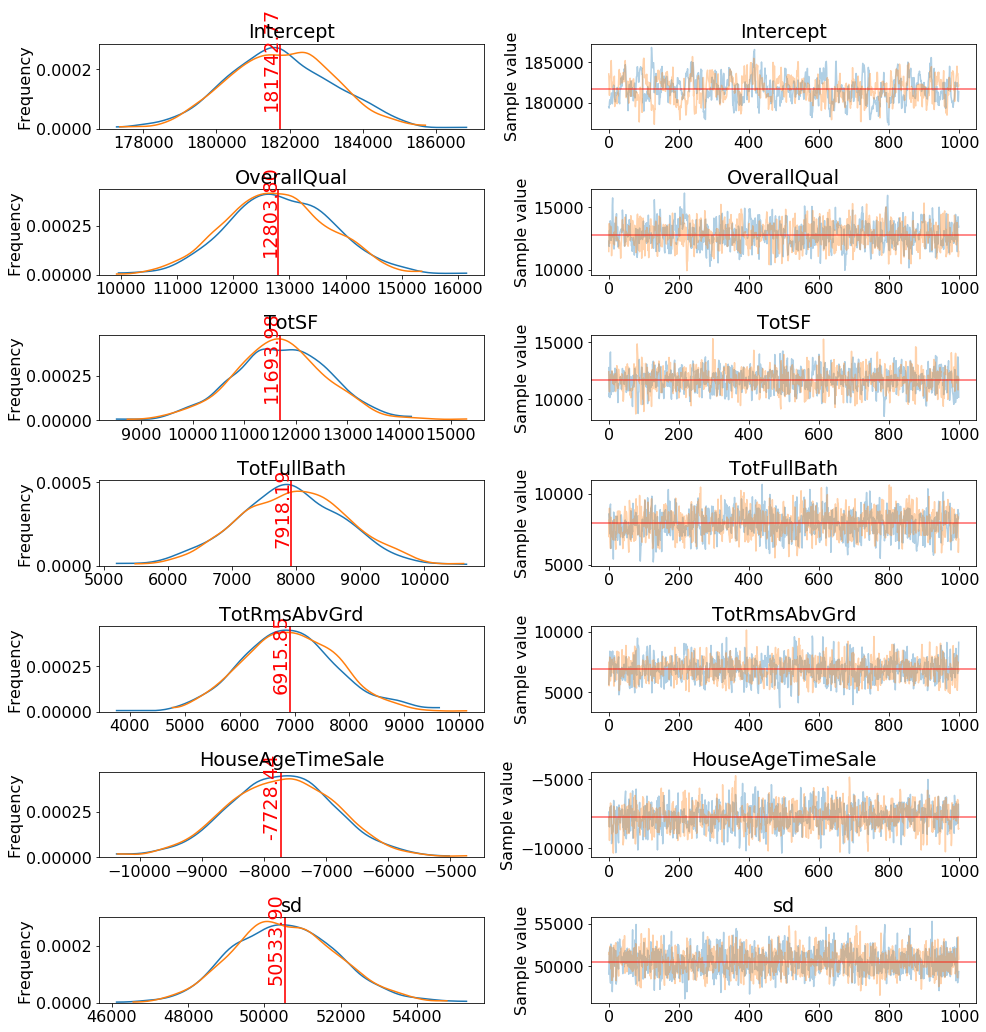

In [67]:
plot_trace(normal_trace);

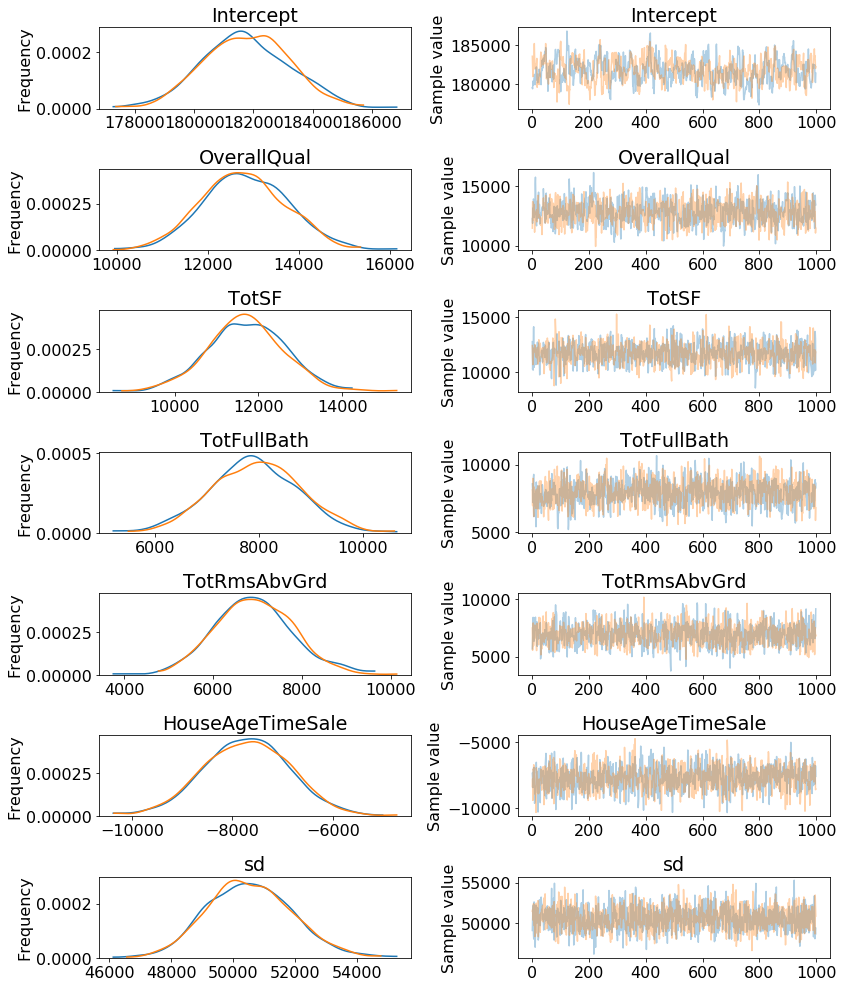

In [68]:
pm.traceplot(normal_trace);

As above, the left side of the traceplot is the marginal posterior: the values for the variable are on the x-axis with the probability for the variable (as determined by sampling) on the y-axis. The different coloured lines indicate that two chains of Markov Chain Monte Carlo were performed. From the left side, it is seen that there are a range of values for each weight. The right side shows the different sample values drawn as the sampling process runs.

The forestplot shows the distribution of each sampled parameter, and so shows the uncertainty in each sample.

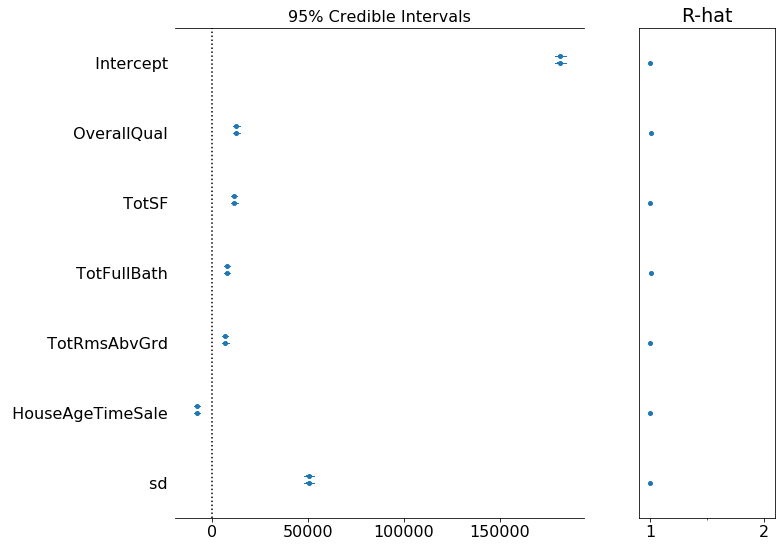

In [69]:
#forestplot
pm.forestplot(normal_trace);

The forest plot shows the most likely value of the parameter (the dot) as well as the 95% credible interval for the parameter. All variables appear to have low uncertainty.

The posterior distribution of all the model parameters show how the model result is a distribution for the parameters rather than a single value.

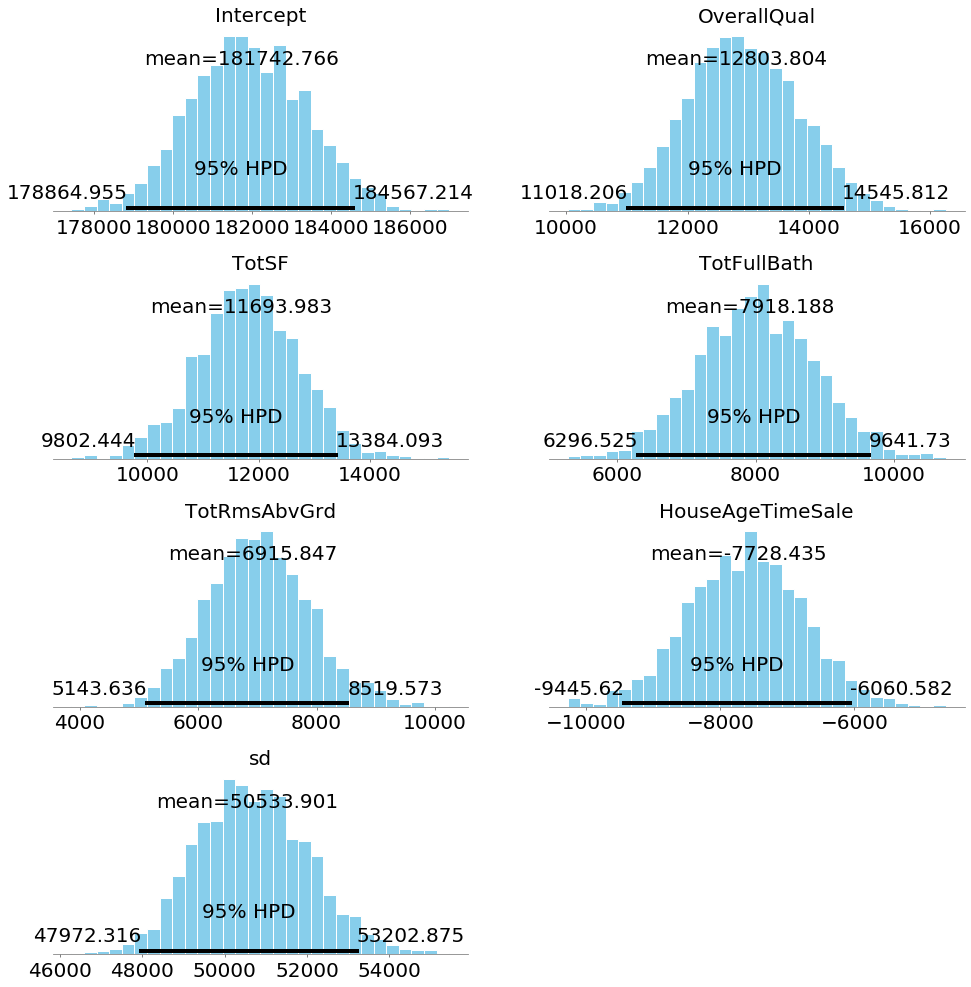

In [70]:
#posterior distribution
pm.plot_posterior(normal_trace, figsize = (14, 14), text_size=20);

In [71]:
#print mean variable weight from trace
for variable in normal_trace.varnames:
    print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
                                                                np.mean(normal_trace[variable])))

Variable: Intercept       Mean weight in model: 181742.7660
Variable: OverallQual     Mean weight in model: 12803.8045
Variable: TotSF           Mean weight in model: 11693.9828
Variable: TotFullBath     Mean weight in model: 7918.1882
Variable: TotRmsAbvGrd    Mean weight in model: 6915.8472
Variable: HouseAgeTimeSale Mean weight in model: -7728.4350
Variable: sd_log__        Mean weight in model: 10.8300
Variable: sd              Mean weight in model: 50533.9014


**Interpretations of Weights**

Based on the sign and location of the weights, the following inferences can be made regarding the features in the dataset:
+ House age at the time of sale is negatively related to the house sale price
+ All other variables are positively related to the house sale price

In [72]:
az.summary(normal_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,181742.766,1470.454,178965.214,184415.111,89.735,63.521,269.0,269.0,270.0,571.0,1.01
OverallQual,12803.804,921.173,11144.135,14545.812,33.832,24.038,741.0,735.0,741.0,1118.0,1.00
TotSF,11693.983,915.554,9980.864,13422.056,29.102,20.584,990.0,990.0,989.0,1124.0,1.00
TotFullBath,7918.188,854.291,6413.693,9641.730,27.703,19.706,951.0,940.0,960.0,1005.0,1.00
TotRmsAbvGrd,6915.847,865.100,5257.795,8519.573,28.480,20.316,923.0,907.0,933.0,854.0,1.00
HouseAgeTimeSale,-7728.435,863.151,-9401.977,-6162.123,25.973,18.371,1104.0,1104.0,1104.0,1452.0,1.00
sd,50533.901,1355.891,48226.751,53226.430,35.462,25.190,1462.0,1449.0,1456.0,1568.0,1.00


#### Linear Formula from Bayesian Inference using Mean of Parameters

In [73]:
model_formula = 'price = '
for variable in normal_trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(normal_trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'price =  181742.77 * Intercept + 12803.80 * OverallQual + 11693.98 * TotSF + 7918.19 * TotFullBath + 6915.85 * TotRmsAbvGrd + -7728.44 * HouseAgeTimeSale + 10.83 * sd_log__ + 50533.90 * sd'

#### Evaluate Bayesian Model using Mean of Model Parameters

In [76]:
#evalute MCMC trace and compare to ml models
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results):
    
    #dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    #results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    #means for all weights
    var_means = var_weights.mean(axis=0)
    
    #create intercept column
    X_test['Intercept'] = 1
    
    #align names of test observations and means
    names = X_test.columns[1:]
    X_test = X_test.loc[:, names]
    var_means = var_means[names]
    
    #calculate estimate for each test observation using average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
        
    #metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    print('Model MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))
    
    #add results to comparison dataframe
    model_results.loc['Bayesian LR', :] = [mae, rmse]
    
    plt.figure(figsize=(12, 8))
    
    #plot median absolute percentage error of all models
    ax = plt.subplot(1, 2, 1)
    model_results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'r', ax = ax)
    plt.title('Model Mean Absolute Error Comparison'); plt.ylabel('MAE'); 
    plt.tight_layout()
    
    #plot RMSE of all models
    ax = plt.subplot(1, 2, 2)
    model_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b', ax = ax)
    plt.title('Model RMSE Comparison'); plt.ylabel('RMSE')
    
    return model_results

Model MAE: 33555.2202
Model RMSE: 53845.0004


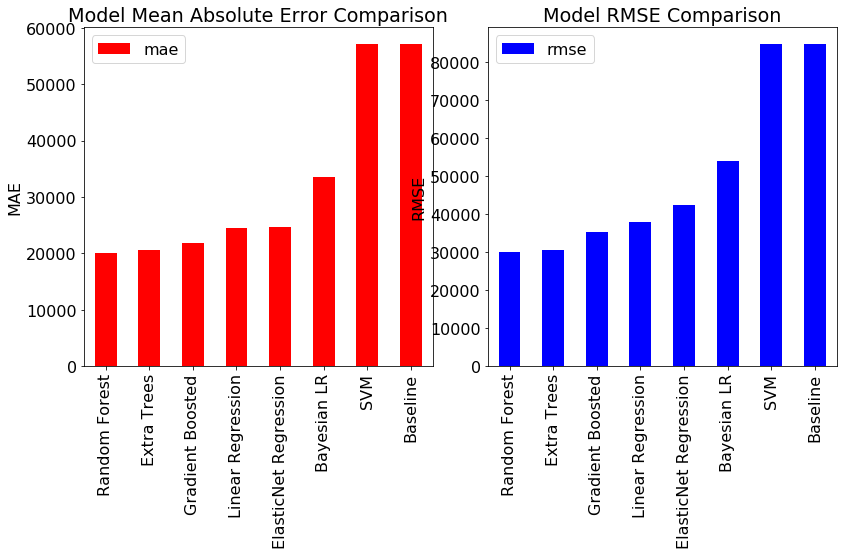

In [77]:
all_model_results = evaluate_trace(normal_trace, X_train, X_test, y_train, y_test, results)

In [78]:
all_model_results

,mae,rmse
Linear Regression,24522.3,38013.2
ElasticNet Regression,24696.2,42239.6
Random Forest,20016.1,29912.9
Extra Trees,20678.2,30560.6
SVM,57104.8,84690.9
Gradient Boosted,21879.5,35365
Baseline,57217.3,84787.1
Bayesian LR,33555.2,53845


### Making Predictions from the model
#### Test Observations

In [157]:
#make new prediction from test set and compare to actual value
def test_model(trace, test_observation):
    
    #print test observation data
    print('Test Observation:')
    print(test_observation)
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    #results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    #standard deviation of likelihood
    sd_value = var_weights['sd'].mean()

    #actual value
    actual = test_observation['SalePrice']
    
    #add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('SalePrice')
    
    #align weights and test observation
    var_weights = var_weights[test_observation.index]

    #means for all weights
    var_means = var_weights.mean(axis=0)

    #location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    #estimates of price
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)

    #plot all estimates
    plt.figure(figsize(8, 8))
    plt.hist(estimates, bins=25, label='Estimated Dist.') 
      
    #plot actual price
    plt.axvline(x = actual,
                ymin = 0, ymax = 5,
                linestyle = '--', color = 'red',
                label = 'True Price',linewidth = 2.5)
    
    #plot mean estimate
    plt.axvline(x = mean_loc, ymin = 0, ymax = 5,
                linestyle = '-', color = 'orange',
                label = 'Mean Estimate',
                linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('Price'); plt.ylabel('Density');
    
    #prediction information
    print('True Price = %d' % actual)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

Test Observation:
SalePrice           205000.000000
OverallQual              0.637073
TotSF                    0.801489
TotFullBath              1.374020
TotRmsAbvGrd             0.883804
HouseAgeTimeSale        -0.676417
Intercept                1.000000
Name: 244, dtype: float64
True Price = 205000
Average Estimate = 221491.9792
5% Estimate = 136364.8616    95% Estimate = 302356.9994


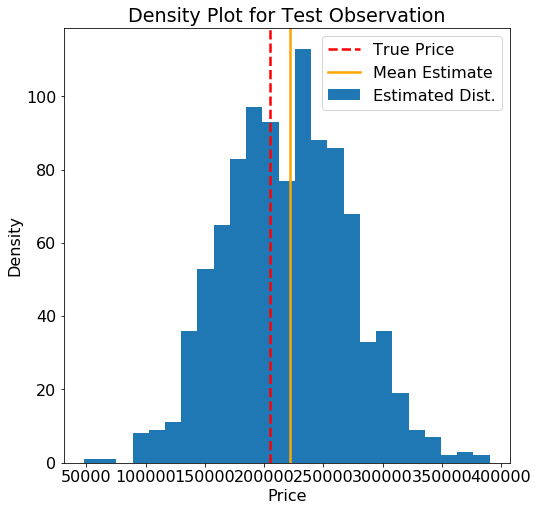

In [158]:
test_model(normal_trace, X_test.iloc[41])

Test Observation:
SalePrice           183500.000000
OverallQual              0.637073
TotSF                    0.124093
TotFullBath              0.000000
TotRmsAbvGrd             0.268177
HouseAgeTimeSale        -1.101005
Intercept                1.000000
Name: 168, dtype: float64
True Price = 183500
Average Estimate = 201714.5803
5% Estimate = 121221.7500    95% Estimate = 281600.3669


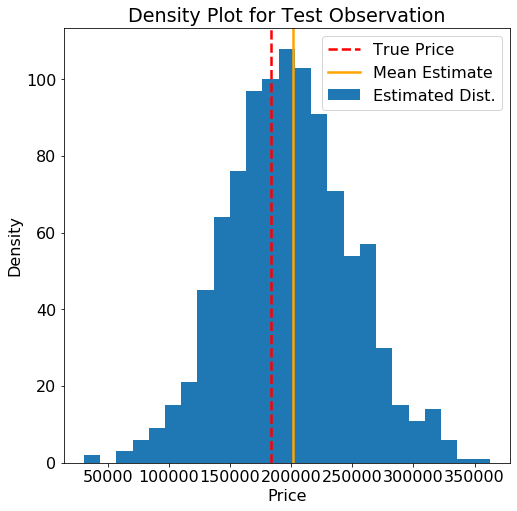

In [159]:
test_model(normal_trace, X_test.iloc[16])

#### Predictions for New Observation

In [162]:
#function to make predictions for new data point from model trace
def query_model(trace, new_observation):
    
    print('New Observation')
    print(new_observation)
    
    #dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    #standard deviation
    sd_value = var_dict['sd'].mean()
    
    #results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    #align weights and new observation
    var_weights = var_weights[new_observation.index]
    
    #means of variables
    var_means = var_weights.mean(axis=0)
    
    #mean for observation
    mean_loc = np.dot(var_means, new_observation)
    
    #distribution of estimates
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 100)
    
    #plot estimate distribution
    plt.figure(figsize(8, 8))
    plt.hist(estimates, bins=25, label='Estimated Dist.') 

    #plot the mean estimate
    plt.axvline(x = mean_loc, ymin = 0, ymax = 5, 
               linestyle = '-', color = 'orange', linewidth = 2.5)
    plt.title('Density Plot for New Observation');
    plt.xlabel('Price'); plt.ylabel('Density');
    
    #estimate information
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

New Observation
Intercept           1.0
OverallQual         0.5
TotSF               0.5
TotFullBath        -1.0
TotRmsAbvGrd        0.5
HouseAgeTimeSale    1.0
dtype: float64
Average Estimate = 181802.9599
5% Estimate = 99708.9313    95% Estimate = 268787.6214


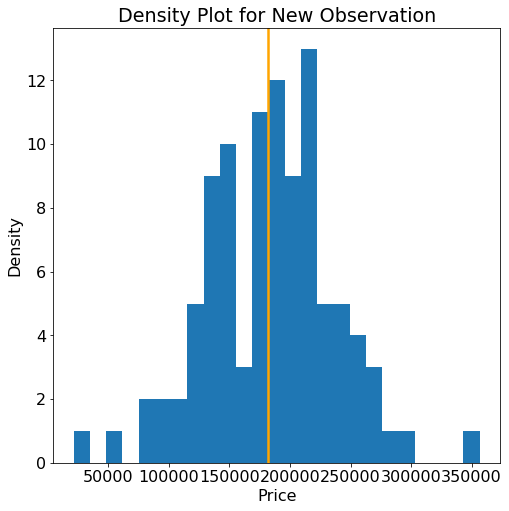

In [163]:
observation = pd.Series({'Intercept': 1, 'OverallQual': 0.5, 'TotSF': 0.5, 
                            'TotFullBath': -1.0, 'TotRmsAbvGrd': 0.5,
                            'HouseAgeTimeSale': 1})
query_model(normal_trace, observation)

### Model Variable Effects

To see the effect of changing one variable while holding the others constant, the function pm.plot_posterior_predictive_glm can be used. This takes a range of values to use for the variable, a linear model, and a number of samples. The function evaluates the linear model across the range of values for the number of samples. Each time, it draws a different set of parameters from the trace. This provides an indication of the effect of a single variable and the uncertainty in the model estimates. To see the effect of a single variable, the other variables are held constant at their median values.

In [97]:
#function to examine effect of changing a single variable
#takes in name of variable, trace, and data
def model_effect(query_var, trace, X):
    
    #variables that do not change
    steady_vars = list(X.columns)
    steady_vars.remove(query_var)
    
    #Linear Model that estimates a price based on value of query variable 
    #and one sample from the trace
    def lm(value, sample):
        
        #prediction is estimate given a value of the query variable
        prediction = sample['Intercept'] + sample[query_var] * value
        
        #each non-query variable is assumed to be at the median value
        for var in steady_vars:
            
            #multiply weight by median value of the variable
            prediction += sample[var] * X[var].median()
        
        return prediction
    
    figsize(6, 6)
    
    #find minimum and maximum values for the range of the query var
    var_min = X[query_var].min()
    var_max = X[query_var].max()
    
    #plot estimated price versus the range of query variable
    pm.plot_posterior_predictive_glm(trace, eval=np.linspace(var_min, var_max, 100), 
                                     lm=lm, samples=100, color='blue', 
                                     alpha = 0.4, lw = 2)
    
    #plot formatting
    plt.xlabel('%s' % query_var, size = 16)
    plt.ylabel('Price', size = 16)
    plt.title("Posterior of Price vs %s" % query_var, size = 18)
    plt.show()

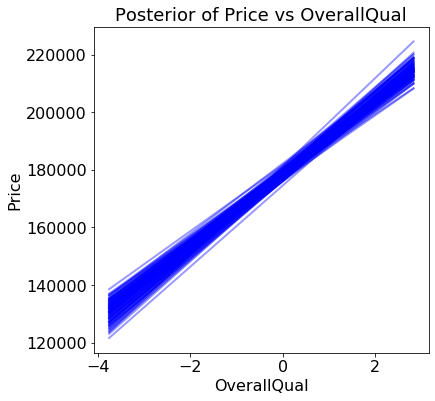

In [98]:
model_effect('OverallQual', normal_trace, X_train.drop(columns='SalePrice'))

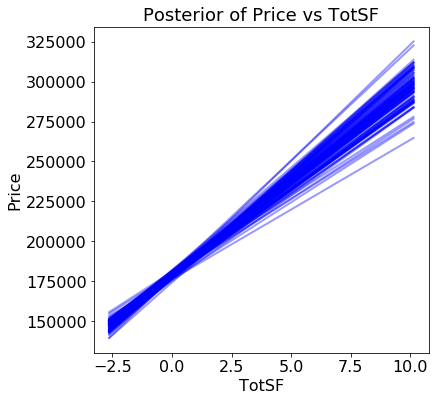

In [99]:
model_effect('TotSF', normal_trace, X_train.drop(columns='SalePrice'))

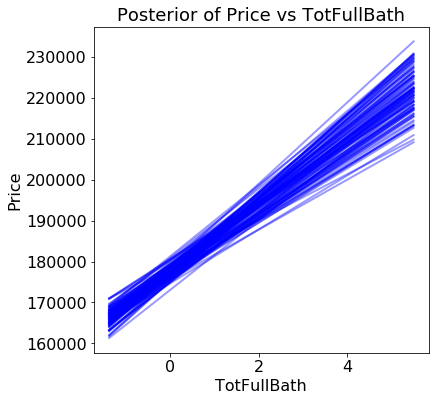

In [100]:
model_effect('TotFullBath', normal_trace, X_train.drop(columns='SalePrice'))

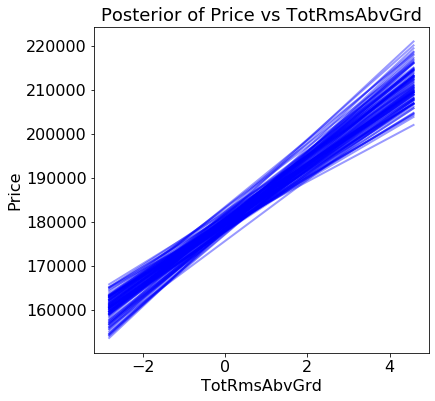

In [101]:
model_effect('TotRmsAbvGrd', normal_trace, X_train.drop(columns='SalePrice'))

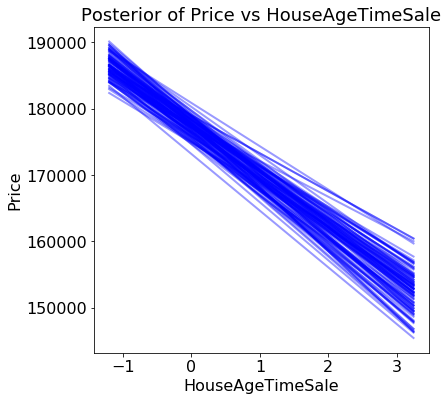

In [102]:
model_effect('HouseAgeTimeSale', normal_trace, X_train.drop(columns='SalePrice'))

## Different Likelihood Prior Distribution

Bayesian Linear Modelling can be performed using a Student's T-distribution as the prior for the data likelihood. A Student's T Distribution has more weight in the tails of the distribution so it is more robust to outliers. For this dataset, the previous exploration suggests a positive skew (majority of prices lower than the mean, but a small number are much higher).

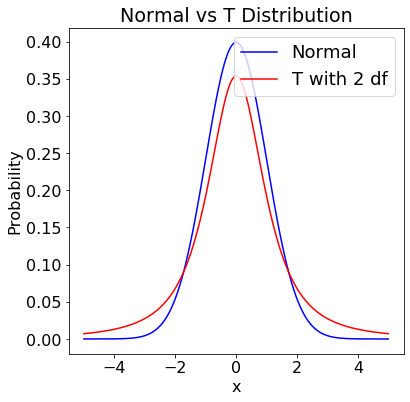

In [103]:
#x values for plotting
x = np.linspace(-5, 5, num = 500)

#generate pdf of normal distribution
y_norm = scipy.stats.norm.pdf(x)

#pdf of t-distribution with 2 degrees of freedom
y_t = scipy.stats.t.pdf(x, df = 2)

plt.plot(x, y_norm, 'b-', label = 'Normal')
plt.plot(x, y_t, 'r-', label = 'T with 2 df')
plt.legend(prop = {'size': 18}, loc = 1)
plt.xlabel('x'); plt.ylabel('Probability'); plt.title('Normal vs T Distribution');

#### Build Model and Perform Inference

In [104]:
#context for model
with pm.Model() as t_model:
    #family is Student's T in this case
    family = pm.glm.families.StudentT(df = 2)
    
    #formula, data, family
    pm.GLM.from_formula(formula, data = X_train, family = family)
    
    #sample from the posterior 
    t_trace = pm.sample(draws=2000, tune=500, njobs = -1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, HouseAgeTimeSale, TotRmsAbvGrd, TotFullBath, TotSF, OverallQual, Intercept]
100%|██████████| 2500/2500 [00:09<00:00, 273.72it/s]
The acceptance probability does not match the target. It is 0.9365304806699314, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9405642179215924, but should be close to 0.8. Try to increase the number of tuning steps.


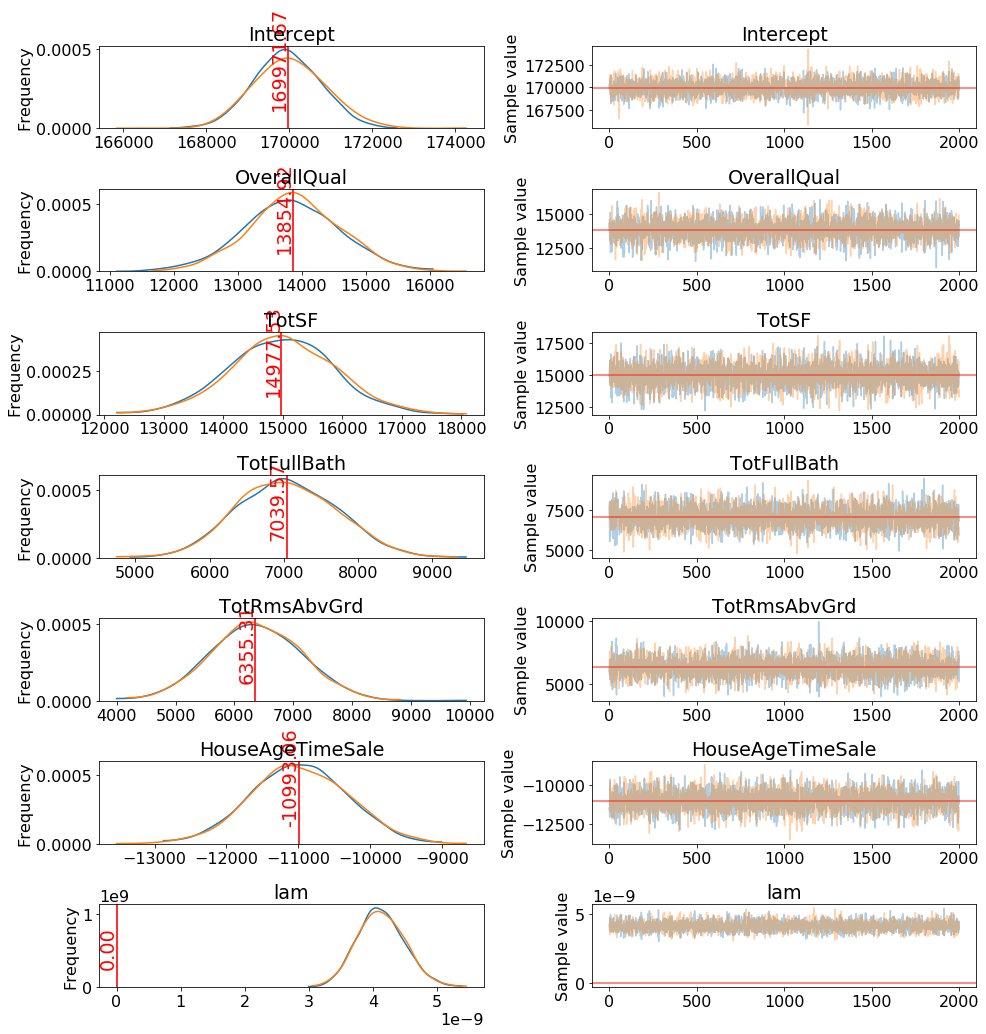

In [105]:
plot_trace(t_trace);

#### Test the Model

In [166]:
def test_model_t(trace, test_observation):
    
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    #results into a dataframe
    var_weights = pd.DataFrame(var_dict)

    #actual Value
    actual = test_observation['SalePrice']
    
    #add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('SalePrice')
    
    #align weights and test observation
    var_weights = var_weights[test_observation.index]

    #means for all the weights
    var_means = var_weights.mean(axis=0)

    #location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    #estimates of grade
    estimates = mean_loc + np.random.standard_t(df = 2, size = 1000)

    plt.figure(figsize(8, 8))
    plt.hist(estimates, bins = 25, label = 'Estimated Dist.')
    
    plt.axvline(x = actual, ymin = 0, ymax = 5, 
               linestyle = '--', color = 'red',
               label = 'True Price',
              linewidth = 2.5)
    plt.axvline(x = mean_loc, ymin = 0, ymax = 5, 
               linestyle = '-', color = 'orange',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('Price'); plt.ylabel('Density');
    
    print('True Price = %d' % actual)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

Test Observation:
SalePrice           68500.000000
OverallQual            -1.558925
TotSF                  -1.950817
TotFullBath            -1.374020
TotRmsAbvGrd           -1.578703
HouseAgeTimeSale        1.446521
Intercept               1.000000
Name: 29, dtype: float64
True Price = 68500
Average Estimate = 105992.6243
5% Estimate = 19382.2739    95% Estimate = 188188.5360


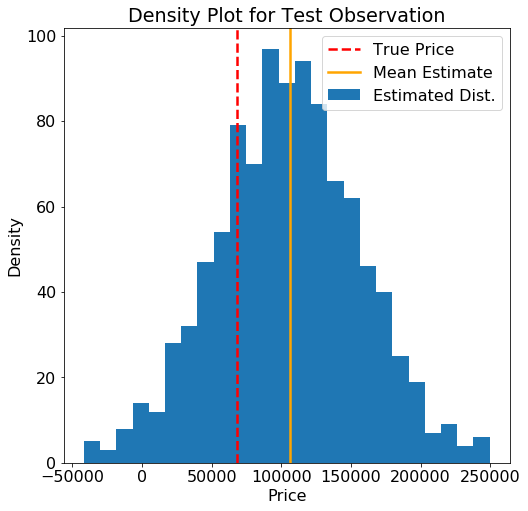

In [168]:
test_model(normal_trace, X_test.iloc[60])

#### New Observation Predictions

In [170]:
def query_model_t(trace, new_observation):
    
    #dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    #results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    #align weights and new observation
    var_weights = var_weights[new_observation.index]
    
    #means of variables
    var_means = var_weights.mean(axis=0)
    
    #mean for observation
    mean_loc = np.dot(var_means, new_observation)
    
    #distribution of estimates
    estimates = mean_loc +  np.random.standard_t(df = 2, size = 1000)

    plt.figure(figsize(8, 8))
    plt.hist(estimates, bins = 19, label = 'Estimated Dist.')
    plt.axvline(x = mean_loc, ymin = 0, ymax = 5, 
               linestyle = '-', color = 'orange', linewidth = 2.5)
    plt.title('Density Plot for New Observation');
    plt.xlabel('Price'); plt.ylabel('Density');
    
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

New Observation
Intercept           1.0
OverallQual         0.5
TotSF               0.5
TotFullBath        -1.0
TotRmsAbvGrd        0.5
HouseAgeTimeSale    1.0
dtype: float64
Average Estimate = 181802.9599
5% Estimate = 96847.3520    95% Estimate = 264669.9205


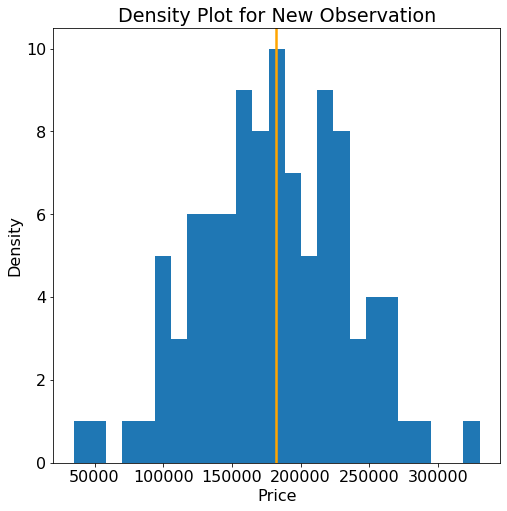

In [171]:
observation = pd.Series({'Intercept': 1, 'OverallQual': 0.5, 'TotSF': 0.5, 
                            'TotFullBath': -1.0, 'TotRmsAbvGrd': 0.5,
                            'HouseAgeTimeSale': 1})
query_model(normal_trace, observation)

Average Estimate = 181802.9599
5% Estimate = 96847.3520    95% Estimate = 264669.9205

Average Estimate = 181802.9599
5% Estimate = 99708.9313    95% Estimate = 268787.6214

Both average estimates generated are the the same ($181,802.96). The margin estimates, however, differ - the 5% and 95% estimates are both lower for the t-distribution, which reflects the positive skew of the data distribution.

Something to keep in mind with this example is the small dataset. The problem of selecting appropriate priors in Bayesian Modelling is often overcome when a the dataset is large, as the model learns from increases, the posterior is updated based on new data, so the prior has a lower impact.

In this notebook, Bayesian Linear Regression was used to predict house prices based on 5 variables. Rather than specify probabilities for the Bayesian network, which is basically impossible for continuous variables, the problem was framed as a machine learning task. In addition to the standard machine learning models that learn from observations, Bayesian Linear Regression was also used to create a model mapping the features (house characteristics) to the target (price). The advantages of Bayesian Linear Regression are that if sensible priors are used, a decent estimate with few samples can still be obtained, and the final weights are not a single number, but a distribution composed of every sample drawn during the sampling run. Predictions can then be made using all the sampled weights to form a distribution of expected values rather than a single answer.

The Bayesian Linear Regression did not perform as well as the other methods (although it did do better than baseline). Despite this, it does provide the opportunity to learn another tool for use in evaluating and making sense of data. Bayesian Linear Regression produces intuitive estimates for the model weights and gives predictions for new houses that align with expectations for the factors influencing house sale prices. 